# Learning Theory from First Principles

## Chapter 2 : Introduction to supervised learning

### Generic packages, settings and helper functions



#### Packages

In [ ]:
from google.colab import files
import numpy as np
from numpy.random import randn, rand
from numpy.linalg import svd, norm
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.linear_model import LinearRegression
from scipy.stats import ortho_group
from scipy.special import erfinv, gamma
from scipy.linalg import sqrtm, eigh
from bisect import bisect
import tqdm
import warnings

np.random.seed(seed=1)

#### Settings

The code below is used to standardize the appearance of the graphics. The graphs may appear unevenly sized when displayed in this notebook, but once downloaded they are the correct size.

In [ ]:
# Appearance of the graphs

# adujst font
SMALL_FONT = 5
MED_FONT = 8
BIG_FONT = 12
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.size'] = SMALL_FONT
mpl.rcParams['axes.titlesize'] = SMALL_FONT

# adujst lines and markers
mpl.rcParams['axes.linewidth'] = .3
mpl.rcParams['lines.linewidth'] = .7
mpl.rcParams['lines.markersize'] = 2
mpl.rcParams['patch.linewidth'] = .3
mpl.rcParams['errorbar.capsize'] = 1.5
mpl.rcParams['lines.markeredgewidth'] = .3

# withdraw the ticks
mpl.rcParams['xtick.bottom'] = False
mpl.rcParams['ytick.left'] = False
mpl.rcParams['xtick.major.pad'] = 0
mpl.rcParams['ytick.major.pad'] = 0

# adjust legend box
mpl.rcParams['legend.fancybox'] = 0
mpl.rcParams['legend.shadow'] = 0
mpl.rcParams['legend.framealpha'] = 1

# adjust fig general settings
mpl.rcParams['figure.dpi'] = 600

big_rectangle = (6.5, 3.5) # height = 9 cm, width = 17 cm
medium_rectangle = (4.7, 1.6) # height = 4 cm, width = 12 cm
medium_square = (4.7, 4.7) # height = 12 cm, width = 12 cm
small_rectangle = (2.4, 1.6) # height = 6 cm, width = 4 cm
mpl.rcParams['figure.figsize'] = small_rectangle

inner_space = {'wspace':.5, 'hspace':.5}

# savefig params
mpl.rcParams["savefig.bbox"] = 'tight'

#### Helper functions

In [ ]:
def mse(y_hat, y):
  return np.mean((y - y_hat)**2)

zero_one = np.vectorize(lambda u: 1 if u<0 else 0)
hinge = np.vectorize(lambda u: np.maximum(1-u, 0))
square = np.vectorize(lambda u: (1-u)**2)
logis = np.vectorize(lambda u: np.log(1+np.exp(-u)))

### Figures

#### Figure 2.1

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

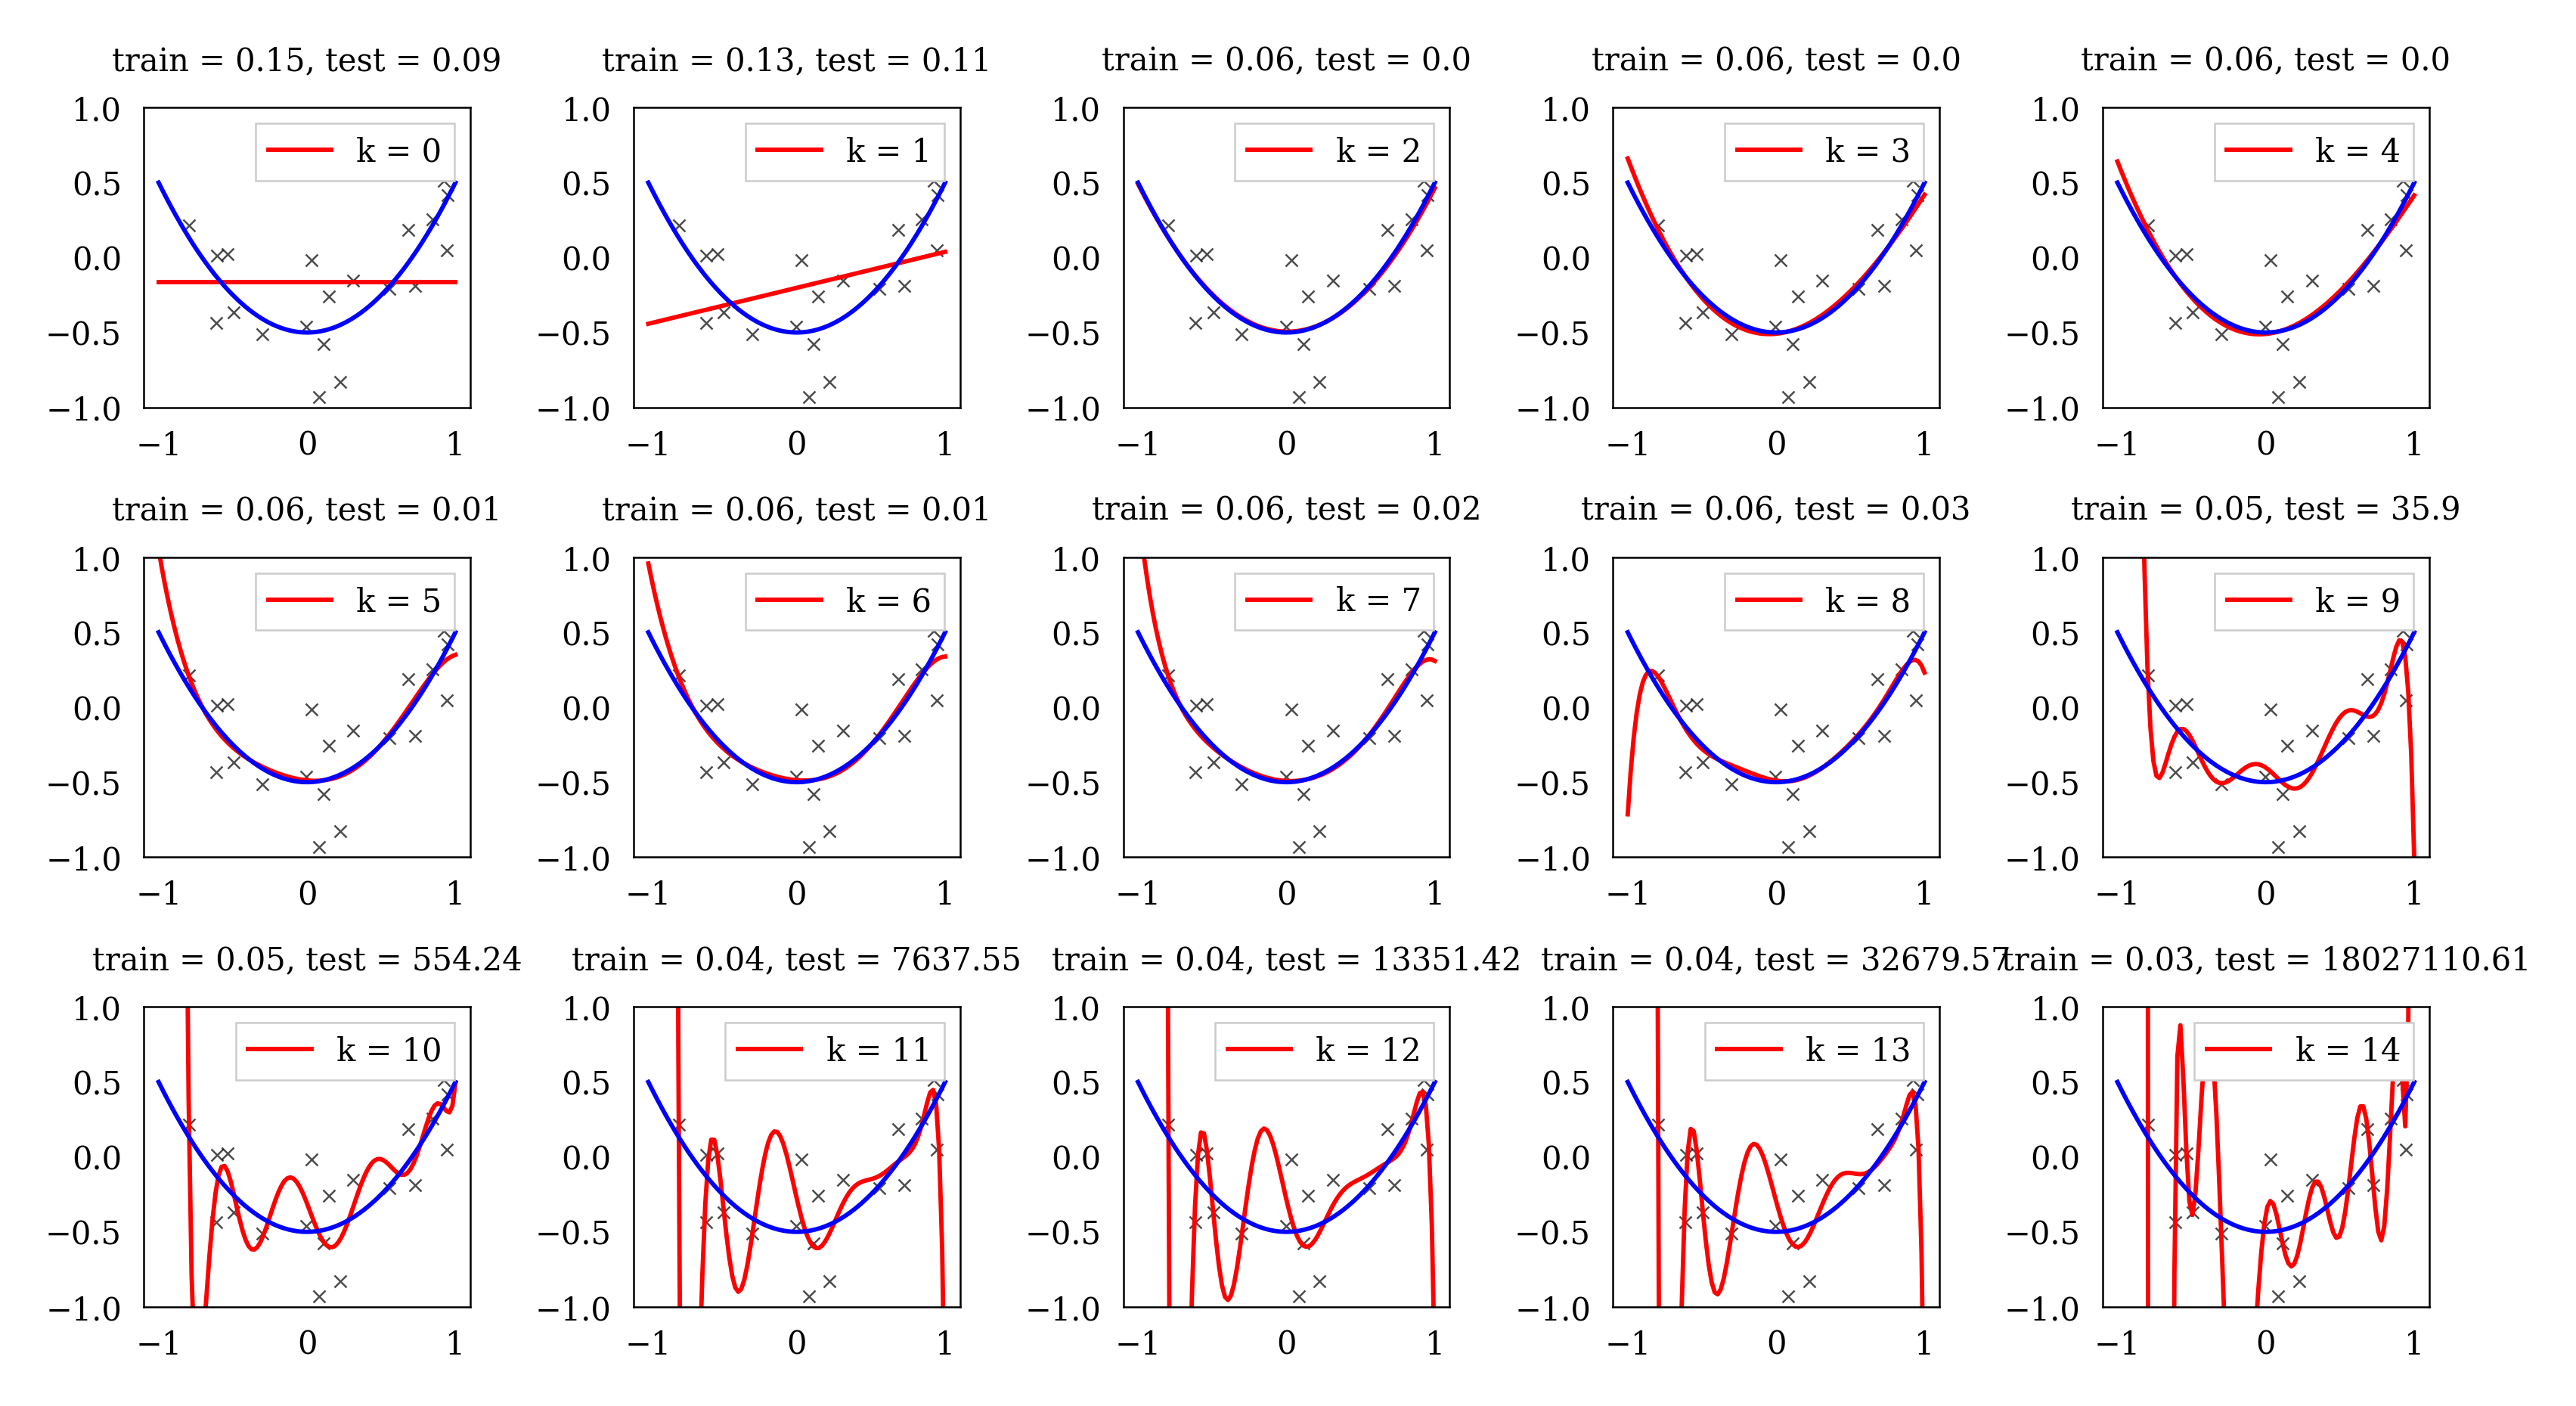

In [ ]:
# fig settings
fig, axs = plt.subplots(nrows=3, ncols=5, figsize=big_rectangle, gridspec_kw = inner_space)

# constants
x_axis = np.linspace(-1, 1, 100)
y_axis = x_axis**2 - 0.5
kmax = 16
n = 20

# samples
x = np.sort(np.random.uniform(-1, 1, n))
y = - 0.5 + x**2 + np.random.normal(scale = 0.25, size=n)

# format data
X = x.reshape(-1, 1)
X_polynom = X**0
x_axis_reshaped = x_axis.reshape(-1, 1)
x_axis_polynom = x_axis_reshaped**0

for i, ax in zip(range(1,kmax),  axs.ravel()):
  # train model
  lin_reg = LinearRegression()
  lin_reg.fit(X_polynom,y)
  coef = np.hstack([lin_reg.coef_[0:-1], lin_reg.intercept_])

  # plot
  ax.set_ylim([-1, 1])
  plt.sca(ax)
  plt.plot(x, y, 'xk', alpha=0.7)
  plt.plot(x_axis, np.polyval(coef, x_axis), color='r', label = 'k = ' + str(i-1))
  plt.plot(x_axis, y_axis, color='b')
  ax.legend(loc='upper right')
  plt.title('train = ' + str(round(mse(lin_reg.predict(X_polynom), y),2))
          + ', test = ' + str(round(mse(lin_reg.predict(x_axis_polynom), y_axis),2)), )

  # initialize next step
  X_polynom = np.hstack([X**i, X_polynom])
  x_axis_polynom = np.hstack([x_axis_reshaped**i, x_axis_polynom])

plt.savefig('fig21.svg')
files.download("fig21.svg")

plt.show()


#### Figure 2.2

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

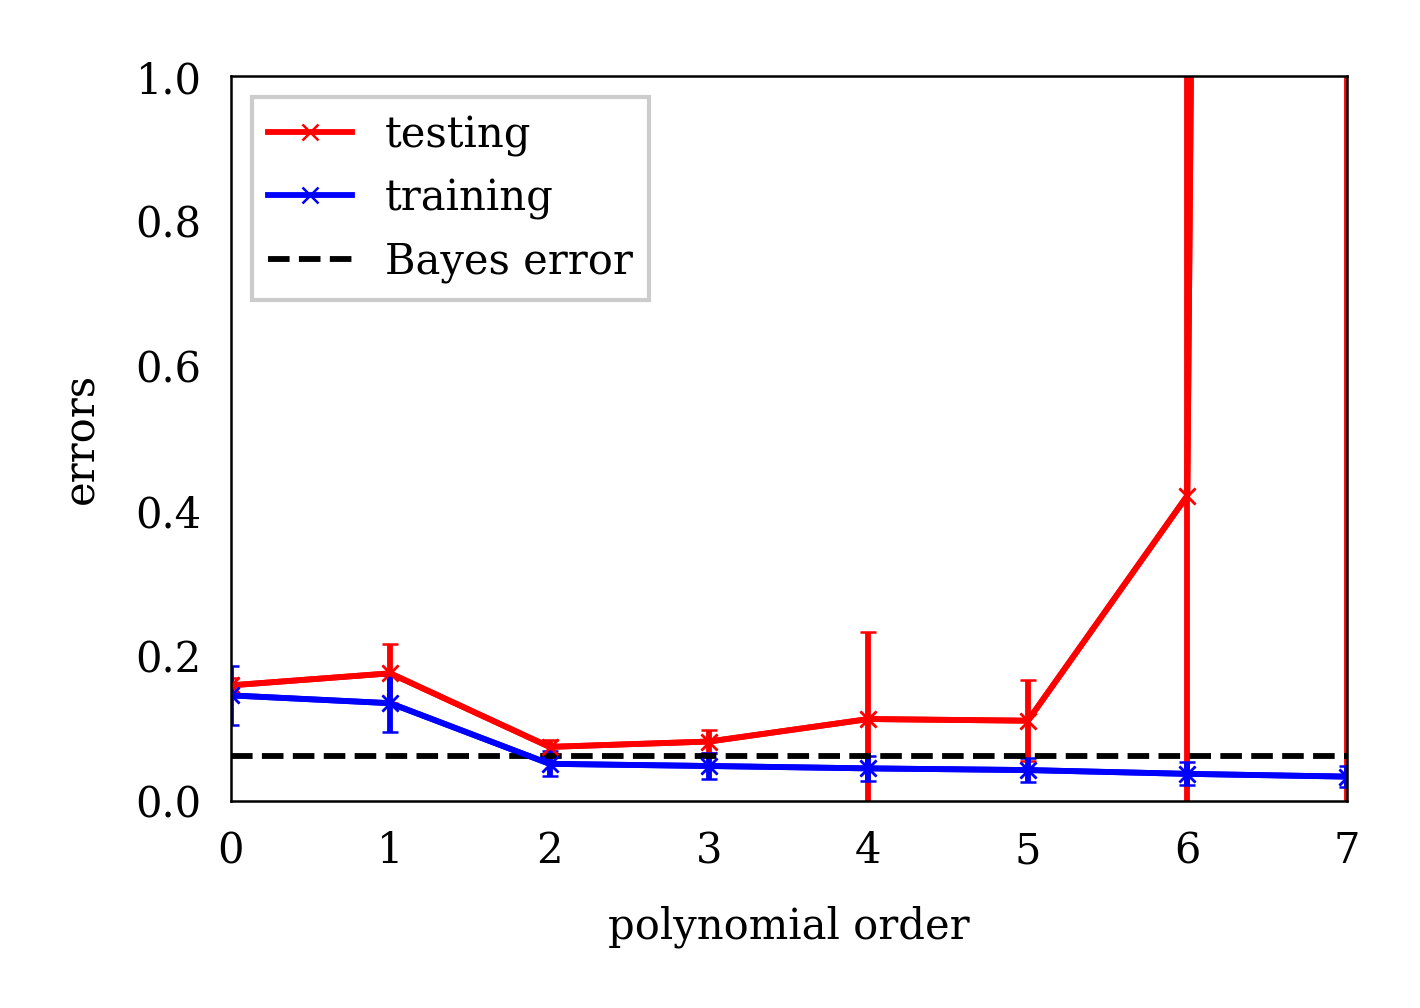

In [ ]:
Xgrid = np.arange(-1, 1.001, 0.001).reshape(-1, 1)

n = 20
std_noise = 0.25
nrep = 32

training_errors = np.zeros((nrep, 8))
testing_errors = np.zeros((nrep, 8))

for irep in range(nrep):
    Xsample = np.random.rand(n,1)*2-1
    Ygrid = Xgrid**2 - 0.5
    Ygrid_with_noise = Xgrid**2 - 0.5 + np.random.randn(len(Ygrid),1) * std_noise
    Ysample = Xsample**2 - 0.5 + np.random.randn(n,1) * std_noise

    kmax = 7
    Xdata = np.ones((n,1))
    Xgriddata = np.ones((len(Xgrid),1))

    for i in range(kmax+1):
        wdata = np.linalg.inv(Xdata.T @ Xdata + n * np.eye(Xdata.shape[1]) * 1e-12) @ Xdata.T @ Ysample
        Ygrid_prediction = Xgriddata @ wdata
        training_errors[irep, i] = np.mean((Xdata @ wdata - Ysample)**2)
        testing_errors[irep, i] = std_noise**2 + np.mean((Ygrid_prediction - Ygrid)**2)
        Xdata = np.hstack((Xdata, Xsample**(i+1)))
        Xgriddata = np.hstack((Xgriddata, Xgrid**(i+1)))

plt.plot(np.arange(kmax + 1), np.mean(testing_errors, axis=0), '-rx')
plt.plot(np.arange(kmax + 1), np.mean(training_errors, axis=0), '-bx')

plt.errorbar(np.arange(kmax + 1), np.mean(testing_errors, axis=0), yerr=np.std(testing_errors, axis=0), fmt='-rx')
plt.errorbar(np.arange(kmax + 1), np.mean(training_errors, axis=0), yerr=np.std(training_errors, axis=0), fmt='-bx')
plt.plot(np.arange(kmax + 1), np.ones(kmax + 1) * (std_noise ** 2), 'k--')

plt.axis([0, kmax, 0, 1])
plt.xlabel('polynomial order')
plt.ylabel('errors')
plt.legend(['testing', 'training', 'Bayes error'], loc="upper left")

plt.savefig('fig22.svg')
files.download("fig22.svg")

plt.show()
